In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import json

from statsmodels.sandbox.stats.multicomp import multipletests
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.sandbox.stats.multicomp import TukeyHSDResults

%matplotlib inline

# 1. Review of Hypothesis Tests

In [2]:
np.random.seed(6)

In [3]:
x = np.random.randn(10, 100)
x[:, :50] = x[:, :50] + 0.5

In [4]:
t, p_value = stats.ttest_1samp(x[:, 0], 0)

In [5]:
p_value

0.4791635379320639

In [6]:
p_values = np.zeros(100)
for i in range(100):
    p_values[i] = stats.ttest_1samp(x[:, i], 0).pvalue

In [7]:
decisions = np.where(p_values <= 0.05, 'Reject H0', 'Do not reject H0')

In [8]:
pd.crosstab(decisions, np.array(['H0 is False'] * 50 + ['H0 is True'] * 50)).rename_axis(index='', columns='')

,H0 is False,H0 is True
,,
Do not reject H0,34,50
Reject H0,16,0


In [9]:
x = np.random.randn(10, 100)
x[:, :50] = x[:, :50] + 1

for i in range(100):
    p_values[i] = stats.ttest_1samp(x[:, i], 0).pvalue
    
decisions = np.where(p_values <= 0.05, 'Reject H0', 'Do not reject H0')
pd.crosstab(decisions, np.array(['H0 is False'] * 50 + ['H0 is True'] * 50))\
    .rename_axis(index='', columns='')

,H0 is False,H0 is True
,,
Do not reject H0,7,49
Reject H0,43,1


# 2. The Family-Wise Error Rate

In [10]:
m = np.arange(1, 501)
fwe1 = 1 - (1 - 0.05) ** m
fwe2 = 1 - (1 - 0.01) ** m
fwe3 = 1 - (1 - 0.001) ** m

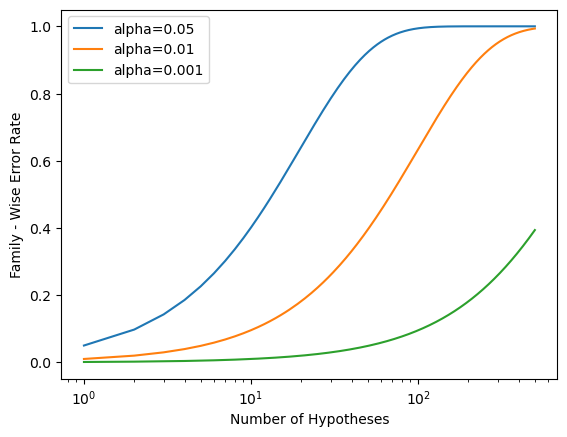

In [11]:
fig, ax = plt.subplots()
ax.set_ylim(-0.05, 1.05)
ax.set_xlabel('Number of Hypotheses')
ax.set_ylabel('Family - Wise Error Rate')
ax.plot(m, fwe1, label='alpha=0.05')
ax.plot(m, fwe2, label='alpha=0.01')
ax.plot(m, fwe3, label='alpha=0.001')
ax.set_xscale('log')
ax.legend()

In [12]:
fund = pd.read_csv('data/Fund.csv', index_col=0)
fund_mini = fund.iloc[:, :5]

In [13]:
t, p_value = stats.ttest_1samp(fund_mini.iloc[:, 0], 0)
p_value

0.0062023554855382655

In [14]:
t

2.860387767736774

In [15]:
fund_pvalue = np.zeros(5)
for i in range(5):
    fund_pvalue[i] = stats.ttest_1samp(fund_mini.iloc[:, i], 0).pvalue
fund_pvalue

array([0.00620236, 0.91827115, 0.01160098, 0.6005396 , 0.75578151])

In [16]:
multipletests(fund_pvalue, method='bonferroni')[1]

array([0.03101178, 1.        , 0.05800491, 1.        , 1.        ])

In [17]:
fund_mini.mean()

Manager1    3.0
Manager2   -0.1
Manager3    2.8
Manager4    0.5
Manager5    0.3
dtype: float64

In [18]:
t, p_value = stats.ttest_rel(fund_mini.iloc[:, 0], fund_mini.iloc[:, 1])
t, p_value

(2.1280149481489823, 0.038391072368079586)

In [19]:
returns = fund_mini.values.flatten(order='F')
manager = np.repeat(['1', '2', '3', '4', '5'], [50] * 5)

In [20]:
tukey = pairwise_tukeyhsd(endog=returns, groups=manager, alpha=0.05)

In [21]:
print(tukey)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     1      2     -3.1 0.1862 -6.9865 0.7865  False
     1      3     -0.2 0.9999 -4.0865 3.6865  False
     1      4     -2.5 0.3948 -6.3865 1.3865  False
     1      5     -2.7 0.3152 -6.5865 1.1865  False
     2      3      2.9 0.2453 -0.9865 6.7865  False
     2      4      0.6 0.9932 -3.2865 4.4865  False
     2      5      0.4 0.9986 -3.4865 4.2865  False
     3      4     -2.3  0.482 -6.1865 1.5865  False
     3      5     -2.5 0.3948 -6.3865 1.3865  False
     4      5     -0.2 0.9999 -4.0865 3.6865  False
---------------------------------------------------


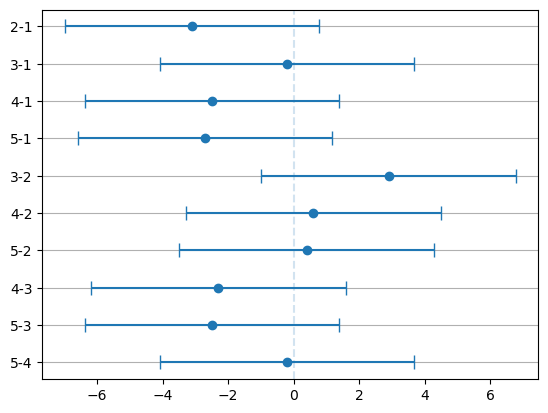

In [22]:
labels = []
for i in range(1, 6):
    for j in range(i+1, 6):
        labels.append(f'{j}-{i}')
        
plt.errorbar(tukey.meandiffs, np.arange(10, 0, -1), 
             xerr=tukey.meandiffs - tukey.confint[:, 0], 
             fmt='o', capsize=5)
plt.axvline(0, alpha=0.2, ls='--')
plt.yticks(ticks=np.arange(10, 0, -1), labels=labels)
plt.grid(axis='y')

# 3. The False Discovery Rate

In [23]:
fund_pvalues = np.zeros(2000)
for i in range(2000):
    fund_pvalues[i] = stats.ttest_1samp(fund.iloc[:, i], 0).pvalue

In [24]:
q_values_bh = multipletests(fund_pvalues, method='fdr_bh')[1]
q_values_bh[:10]

array([0.08988921, 0.991491  , 0.12211561, 0.92342997, 0.95603587,
       0.07513802, 0.0767015 , 0.07513802, 0.07513802, 0.07513802])

In [25]:
(q_values_bh <= 0.1).sum()

146

In [26]:
(fund_pvalues <= (0.01 / 200)).sum()

0

In [27]:
ps = np.sort(fund_pvalues)
m = fund_pvalues.shape[0]
q = 0.1
wh_ps = np.where(ps < (q * np.arange(1, m + 1) / m))[0] + 1
if len(wh_ps) > 0:
    wh = np.arange(1, wh_ps.max() + 1)
else:
    wh = 0

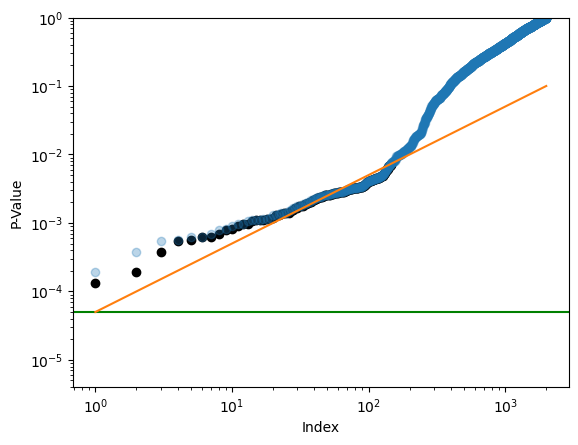

In [28]:
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(4e-6, 1)
ax.set_ylabel('P-Value')
ax.set_xlabel('Index')
ax.scatter(wh, ps[wh-1], c='black')
ax.plot(ps, 'o', alpha=0.3)
ax.axhline(0.1 / 2000, c='green')
ax.plot(np.arange(1, m+1), q * np.arange(1, m+1) / m)

# 4. A Re-Sampling Approach

In [29]:
with open('./data/Khan.json') as f:
    Khan = json.load(f)

X_train = np.array(Khan['xtrain'])
y_train = np.array(Khan['ytrain'])
X_test = np.array(Khan['xtest'])
y_test = np.array(Khan['ytest'])

In [30]:
X = np.r_[X_train, X_test]
y = np.concatenate((y_train, y_test))

In [31]:
X.shape

(83, 2308)

In [32]:
pd.Series(y).value_counts().sort_index()

1    11
2    29
3    18
4    25
dtype: int64

In [33]:
X1 = X[y == 2]
X2 = X[y == 4]
n1 = X1.shape[0]
n2 = X2.shape[0]

In [34]:
t, p_value = stats.ttest_ind(X1[:, 10], X2[:, 10])
t, p_value

(-2.093659633980707, 0.04118396795367352)

In [35]:
np.random.seed(1)
B = 10000
Tbs = np.array([None] * B)
for b in range(B):
    dat = np.random.permutation(np.concatenate((X1[:, 10], X2[:, 10])))
    Tbs[b] = stats.ttest_ind(dat[:n1], dat[n1:]).statistic

In [36]:
(np.abs(Tbs) > np.abs(t)).mean()

0.0392

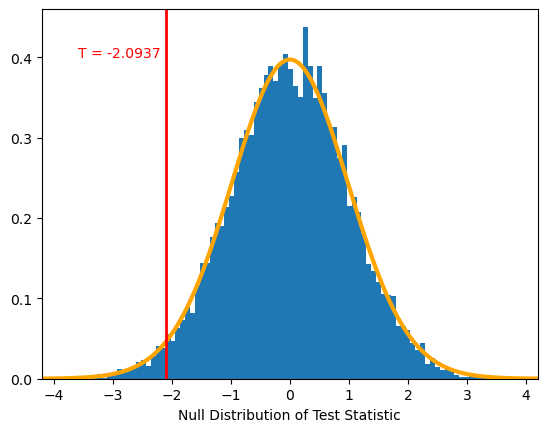

In [37]:
df = n1 + n2 - 2
rv = stats.t(df)
x = np.linspace(-4.2, 4.2, 1000)

plt.hist(Tbs, bins=100, density=True)
plt.xlim(-4.2, 4.2)
plt.xlabel('Null Distribution of Test Statistic')
plt.plot(x, rv.pdf(x), lw=3, c='orange')
plt.axvline(t, color='red', lw=2)
plt.text(t - 1.5, 0.4, f'T = {np.round(t, 4)}', c='red')
plt.show()

In [38]:
m = 100
# B = 500
np.random.seed(1)
index = np.random.choice(X1.shape[1], m, replace=False)
Ts = np.zeros(m)
Ts_star = np.zeros((B, m))

for j in range(m):
    k = index[j]
    Ts[j] = stats.ttest_ind(X1[:, k], X2[:, k]).statistic
    for b in range(B):
        dat = np.random.permutation(np.concatenate((X1[:, k], X2[:, k])))
        Ts_star[b, j] = stats.ttest_ind(dat[:n1], dat[n1:]).statistic

In [39]:
cs = np.sort(np.abs(Ts))
Rs = np.zeros(m)
Vs = np.zeros(m)
for j in range(m):
    Rs[j] = (np.abs(Ts) >= cs[j]).sum()
    Vs[j] = (np.abs(Ts_star) >= cs[j]).sum() / B

FDRs = Vs / Rs

In [40]:
Rs[FDRs <= 0.1].max()

21.0

In [41]:
np.where(np.abs(Ts) >= cs[FDRs < .1].min())

(array([11, 12, 13, 19, 21, 22, 25, 26, 34, 40, 44, 52, 53, 57, 79, 84, 87,
        89, 93, 94, 96], dtype=int64),)

In [42]:
Rs[FDRs <= 0.2].max()

22.0

In [43]:
np.where(np.abs(Ts) >= cs[FDRs < .2].min())

(array([11, 12, 13, 17, 19, 21, 22, 25, 26, 34, 40, 44, 52, 53, 57, 79, 84,
        87, 89, 93, 94, 96], dtype=int64),)

Text(0, 0.5, 'False Discovery Rate')

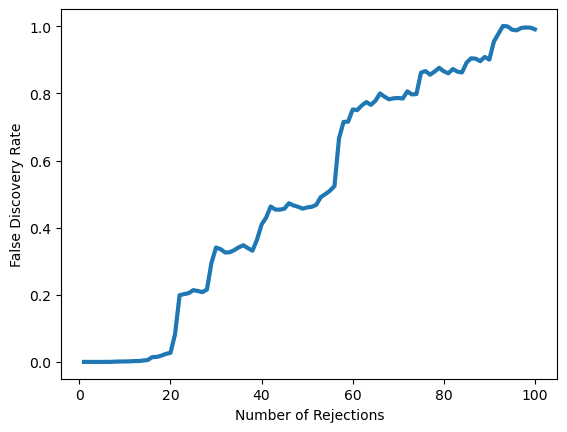

In [44]:
plt.plot(Rs, FDRs, lw=3)
plt.xlabel('Number of Rejections')
plt.ylabel('False Discovery Rate')